<a href="https://colab.research.google.com/github/RobBurnap/Bioinformatics-MICR4203-MICR5203/blob/main/%20%20%20%20Bioinformatics-MICR4203-MICR5203/notebooks/05_Gene_Expression%20/RNA_seq_Data_Exploration_PCA_and_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# L05 — RNA-seq Data Exploration: PCA and Clustering
**BIOINFO4/5203 – Gene Expression Module**

### Goals for Today
- Perform **Principal Component Analysis (PCA)** on standardized RNA-seq data.  
- Visualize global structure in gene expression (scree plot, PCA scatter).  
- Perform **Hierarchical Clustering** and visualize sample clusters.  
- Interpret biological meaning of clusters and principal components.

### Learning Outcomes
Students will learn how dimensionality reduction and clustering reveal biological structure (light vs. shade conditions, time-dependent regulation, etc.) from high-dimensional RNA-seq data.

In [8]:
from google.colab import drive
import os

drive.mount('/content/drive')

COURSE_DIR = "/content/drive/MyDrive/Teaching/BIOINFO4-5203-F25"
LECTURE_CODE = "L05"
TOPIC = "gene_expression_PCA_clustering"

DATA_DIR = f"{COURSE_DIR}/Data/{LECTURE_CODE}_{TOPIC}"
OUTPUT_DIR = f"{COURSE_DIR}/Outputs/{LECTURE_CODE}_{TOPIC}"

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("📂 COURSE_DIR:", COURSE_DIR)
print("📁 DATA_DIR:", DATA_DIR)
print("📁 OUTPUT_DIR:", OUTPUT_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 COURSE_DIR: /content/drive/MyDrive/Teaching/BIOINFO4-5203-F25
📁 DATA_DIR: /content/drive/MyDrive/Teaching/BIOINFO4-5203-F25/Data/L05_gene_expression_PCA_clustering
📁 OUTPUT_DIR: /content/drive/MyDrive/Teaching/BIOINFO4-5203-F25/Outputs/L05_gene_expression_PCA_clustering


## A. Load the Preprocessed RNA-seq Data

We’ll use the standardized RNA-seq data file created earlier in this module.
If your data file is not yet in `.csv` format, convert and save it using the previous notebook.

In [10]:
import pandas as pd
import os

# Corrected folder paths
COURSE_DIR = "/content/drive/MyDrive/Teaching/BIOINFO4-5203-F25"
LECTURE_CODE = "L05"
TOPIC = "gene_expression_PCA_clustering"

DATA_DIR = f"{COURSE_DIR}/Data/{LECTURE_CODE}_{TOPIC}"
OUTPUT_DIR = f"{COURSE_DIR}/Outputs/{LECTURE_CODE}_{TOPIC}"

# Verify path exists
print("📁 Checking data directory:")
print(os.listdir(DATA_DIR))

# Load the RNA-seq file
data_path = f"{DATA_DIR}/High-Light-Pulse.csv"
expr_df = pd.read_csv(data_path, index_col=0)

print(f"✅ Data loaded successfully: {expr_df.shape[0]} genes × {expr_df.shape[1]} samples")
display(expr_df.head())

📁 Checking data directory:
['High-Light-Pulse.csv']
✅ Data loaded successfully: 2723 genes × 5 samples


,JGI ID,0,15,30,60
Gene ID,,,,,
Synpcc7942_0001,637798406,1.03,1.17,1.24,1.33
Synpcc7942_0002,637798407,0.35,0.45,0.44,0.42
Synpcc7942_0003,637798408,0.72,0.76,0.92,0.97
Synpcc7942_0004,637798409,1.11,0.94,1.04,0.95
Synpcc7942_0005,637798410,0.24,0.14,0.12,0.15


## B. Log₂ Transformation and Standardization

We’ll apply a log₂(x + 1) transformation to normalize expression ranges and then standardize features across genes.  
This ensures PCA and clustering reflect **relative differences** in expression patterns rather than absolute counts.

In [12]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Log₂ transform
expr_log = np.log2(expr_df + 1)
expr_log.replace([np.inf, -np.inf], np.nan, inplace=True)
expr_log = expr_log.fillna(expr_log.median())

# Standardize
scaler = StandardScaler()
expr_scaled = pd.DataFrame(
    scaler.fit_transform(expr_log.T).T,
    index=expr_log.index,
    columns=expr_log.columns
)

print("✅ Expression data log-transformed and standardized")
display(expr_scaled.iloc[:5, :5])

✅ Expression data log-transformed and standardized


,JGI ID,0,15,30,60
Gene ID,,,,,
Synpcc7942_0001,1.999966,-0.509707,-0.501152,-0.497080,-0.492027
Synpcc7942_0002,1.999990,-0.505849,-0.496883,-0.497752,-0.499506
Synpcc7942_0003,1.999958,-0.508530,-0.505607,-0.494545,-0.491277
Synpcc7942_0004,1.999985,-0.493719,-0.504447,-0.498028,-0.503790
Synpcc7942_0005,1.999981,-0.491883,-0.502328,-0.504527,-0.501243


## C. Principal Component Analysis (PCA)

PCA is a dimensionality-reduction method that projects data into orthogonal components capturing the largest sources of variation.  
We’ll visualize how much variance is explained by each component and how samples are distributed along PC1 and PC2.

✅ PCA completed with 5 components


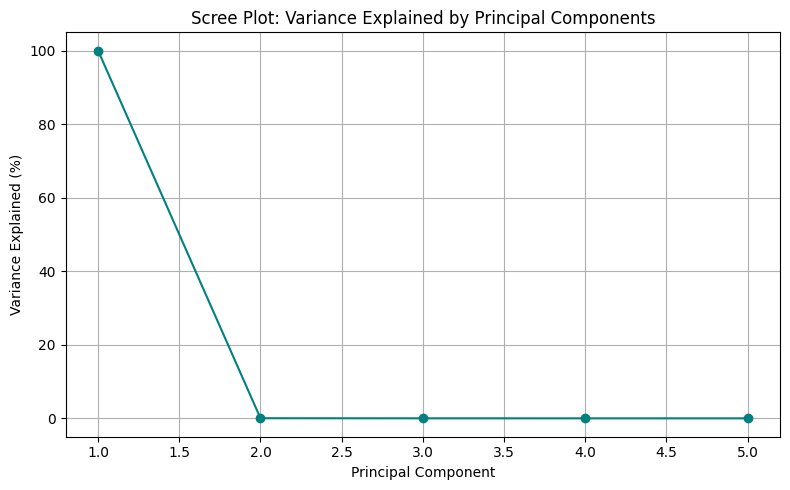

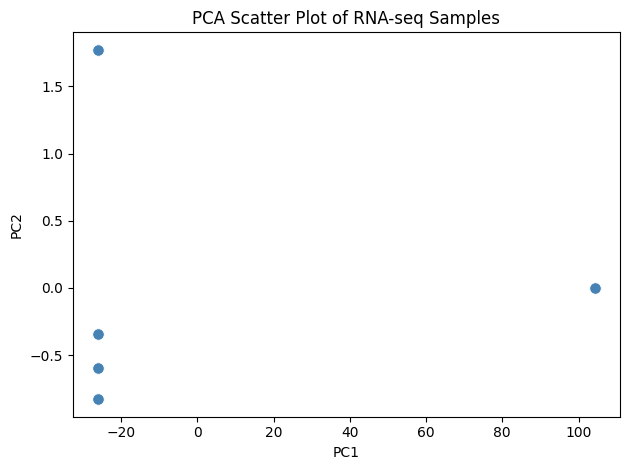

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Adjust PCA to automatically use the valid number of components
n_components = min(expr_scaled.T.shape)
pca = PCA(n_components=n_components)
pca_scores = pca.fit_transform(expr_scaled.T)

print(f"✅ PCA completed with {n_components} components")

# Scree plot
plt.figure(figsize=(8,5))
plt.plot(range(1, n_components + 1),
         pca.explained_variance_ratio_ * 100,
         'o-', color='teal')
plt.title("Scree Plot: Variance Explained by Principal Components")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

# PCA scatter (if ≥2 components)
if n_components >= 2:
    pca_df = pd.DataFrame(pca_scores[:, :2], columns=['PC1', 'PC2'])
    sns.scatterplot(data=pca_df, x='PC1', y='PC2', s=70, color='steelblue')
    plt.title("PCA Scatter Plot of RNA-seq Samples")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ PCA has fewer than 2 components — skipping scatter plot.")

⚠️ **Note for students:**  
The number of PCA components cannot exceed the smaller of:
- the number of genes (rows), and  
- the number of samples (columns).  

In RNA-seq experiments with few conditions or time points, PCA will produce as many components as there are samples.

## D. PCA Loadings: Top Contributing Genes

Each principal component represents a combination of genes weighted by their contribution.  
We’ll identify the **top 10 genes contributing to PC1**, which often correspond to biological pathways or stress responses.

In [16]:
# Create loadings matrix for existing PCA components
loadings = pd.DataFrame(
    pca.components_.T,
    index=expr_scaled.index,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)]
)

# Identify top 10 genes contributing most to PC1
top_genes_pc1 = loadings['PC1'].abs().sort_values(ascending=False).head(10)

print("🧬 Top genes contributing to PC1:")
display(top_genes_pc1)

🧬 Top genes contributing to PC1:


,PC1
Gene ID,
Synpcc7942_R0026,0.019167
Synpcc7942_1441,0.019167
Synpcc7942_1103,0.019167
Synpcc7942_0257,0.019167
Synpcc7942_1708,0.019167
Synpcc7942_B2643,0.019167
Synpcc7942_1381,0.019167
Synpcc7942_1205,0.019167
Synpcc7942_2318,0.019167


### Interpreting PCA Loadings

The **loadings** represent how strongly each gene contributes to each principal component.  
Here we examine the **top 10 genes** with the largest absolute loadings in **PC1**, which often correspond to key biological pathways or stress-response regulators.

### PCA Biplot: Visualizing Genes and Samples

A **biplot** displays both the *samples* (RNA-seq conditions) and *genes* in the same principal component space.  
It helps interpret relationships — for example:
- Which genes drive separation between treatments (loadings)
- How experimental samples cluster by light or time

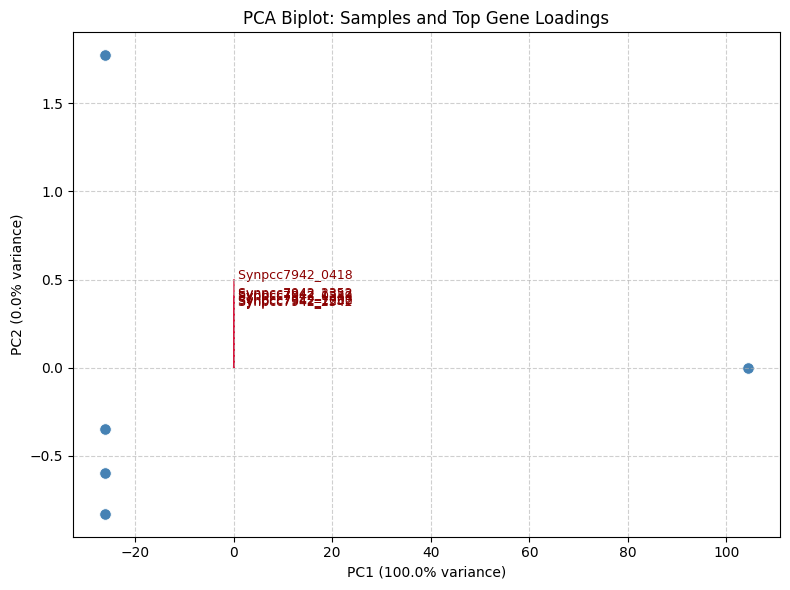

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a DataFrame for PCA scores (samples)
pca_df = pd.DataFrame(
    pca_scores[:, :2],
    columns=['PC1', 'PC2'],
    index=expr_scaled.columns
)

# Identify top genes contributing to PC1 & PC2
n_top = 8  # number of top genes to show as arrows
loadings_subset = loadings[['PC1', 'PC2']]
top_genes = (
    loadings_subset.abs()
    .sum(axis=1)
    .sort_values(ascending=False)
    .head(n_top)
    .index
)

# Scale arrows for better visualization
arrow_scale = 3
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', s=70, color='steelblue')

# Overlay gene loadings as arrows
for gene in top_genes:
    plt.arrow(
        0, 0,
        loadings_subset.loc[gene, 'PC1'] * arrow_scale,
        loadings_subset.loc[gene, 'PC2'] * arrow_scale,
        color='crimson',
        alpha=0.7,
        head_width=0.03
    )
    plt.text(
        loadings_subset.loc[gene, 'PC1'] * arrow_scale * 1.1,
        loadings_subset.loc[gene, 'PC2'] * arrow_scale * 1.1,
        gene,
        fontsize=9,
        color='darkred'
    )

# Titles and annotations
plt.title("PCA Biplot: Samples and Top Gene Loadings")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Hierarchical Clustering and Heatmap

While PCA provides a global view of expression variance, **hierarchical clustering** groups genes and samples by similarity in their expression patterns.  
This visualization is often used to detect co-expressed gene clusters or identify treatments that produce similar transcriptional responses.

Here, we’ll cluster both genes and experimental conditions using the standardized (Z-score transformed) expression matrix.

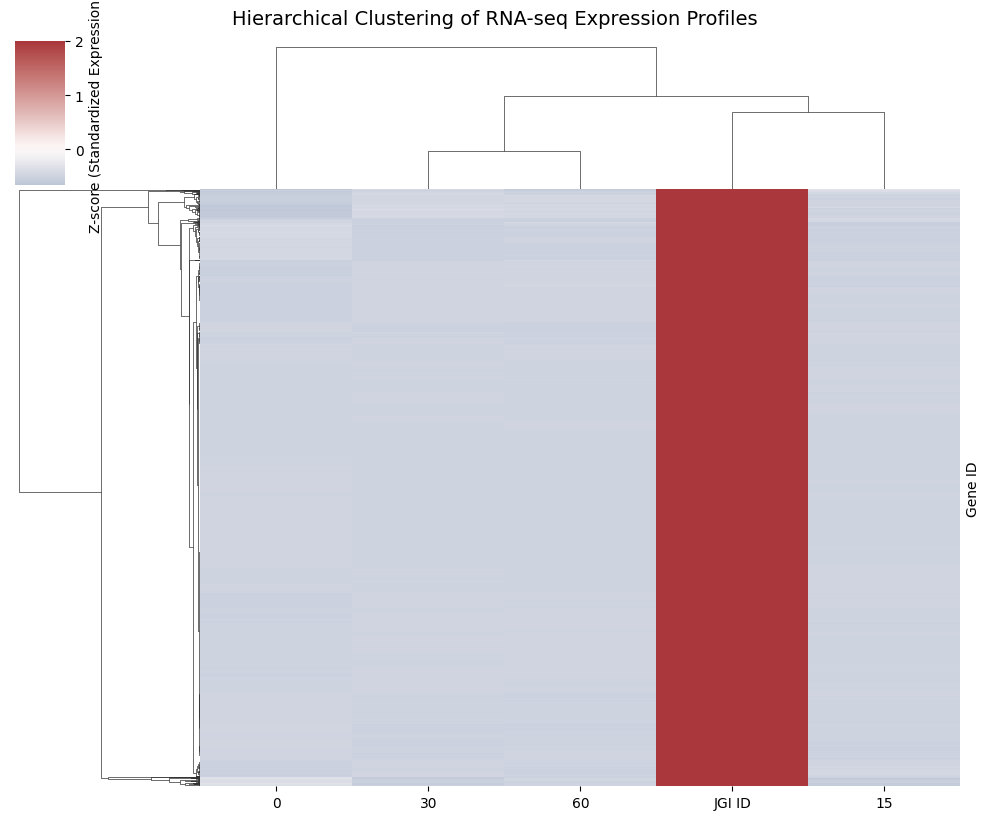

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage

# Compute hierarchical linkage on rows (genes) and columns (samples)
# Using correlation-based distance and average linkage
linkage_genes = linkage(expr_scaled, method='average', metric='correlation')
linkage_samples = linkage(expr_scaled.T, method='average', metric='correlation')

# Generate clustermap
g = sns.clustermap(
    expr_scaled,
    row_linkage=linkage_genes,
    col_linkage=linkage_samples,
    cmap='vlag',              # diverging red/blue color palette
    figsize=(10, 8),
    xticklabels=True,
    yticklabels=False,        # Hide individual gene labels for readability
    center=0,
    cbar_kws={'label': 'Z-score (Standardized Expression)'}
)

plt.suptitle("Hierarchical Clustering of RNA-seq Expression Profiles", y=1.02, fontsize=14)
plt.show()